# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.agent.agent import DnDAgent
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop
from src.agent.training import *
from src.dnd.game_configs import *

In [3]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [5]:
board_size, game_config = get_2v2_1_config()
agent = DnDAgent(board_shape=board_size, in_channels=DnDBoard.STATE_CHANNEL_COUNT, out_actions=2, 
    lr=1e-3, 
    epsilon=0.9, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='exp',
    gamma=0.9,
    batch_size=32, 
    dual_learning=True, 
    replace_model_interval=7000,
    memory_capacity=100000,
    random_action_resolver=get_legal_action_resolver(board_size, False),
    model_class=DnDEvalModelRT5,
    sequential_actions=False
)

train_loop = train_loop_full
reward_policy = reward_full_v1

In [6]:
games = 50000
checkpoint_interval = 4000
game_iter_limit = 2500
average_result_over = 1000

# set to None to disable report / figures export
output_path = '../rnd/2v2-1/'
generation_name = '_temp'
gen_header = \
'''# Gen 15, but after adjusting learning algorithm

'''

In [7]:
iters, eps, checkpoints, reps = [], [], [], []
mag1s, mag2s = [], []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace

report_results = output_path is not None
if report_results:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path, exist_ok=generation_name.startswith('_temp'))
else: gen_path = '..' # so that checkpoints still work

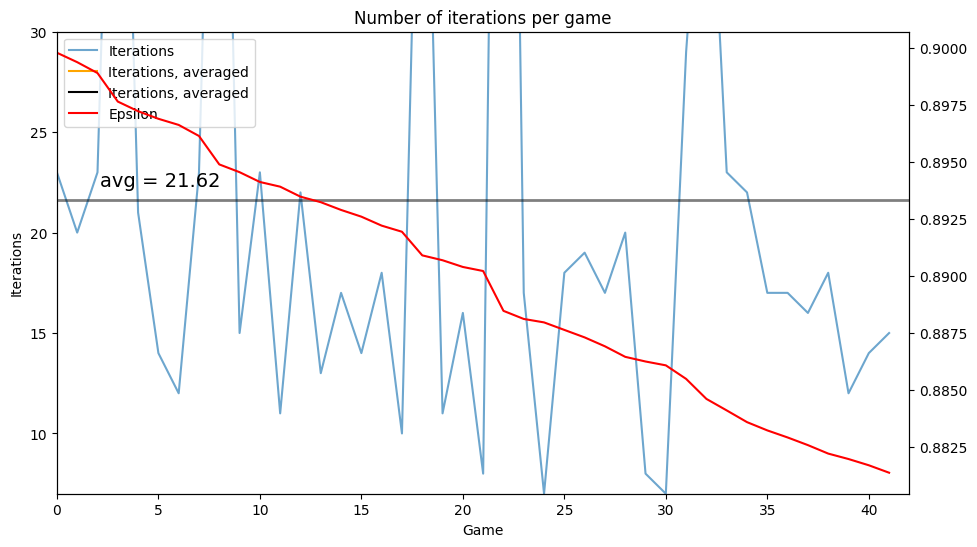

Training:  82%|########2 | 41/50 [01:46<00:21,  2.34s/it, mag1=0.324, mag2=0.943]

In [8]:
last_update = time.time()

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = generate_balanced_game(board_size, game_config)
        
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        iter_count = train_loop(agent, game, reward_policy, iter_limit=game_iter_limit, raise_on_limit=False)
        iters.append(iter_count)
        eps.append(agent.epsilon)

        ctime = time.time()
        if ctime - last_update > 20:
            clear_output(wait=True)
            plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=30, average_last=average_result_over)
            display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_interval:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-average_result_over:]) # recent performance
            agent.save_agent(os.path.join(gen_path, f'checkpoints/agent-{avg:0.1f}i-{iter_i / 1000:0.1f}k'))

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)

In [9]:
np.where(agent.game_over_memory == False)[0][:10]

array([ 55, 101, 154, 293, 340, 377, 407, 461, 600, 638], dtype=int64)

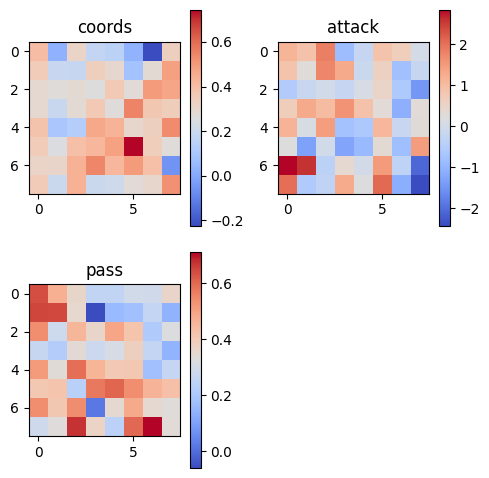

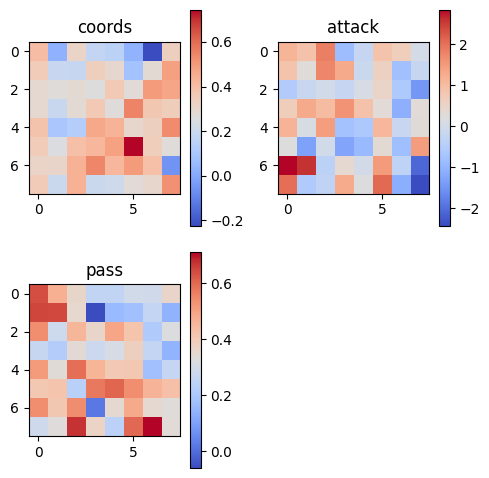

In [20]:
i = 56

evals = agent.predict(agent.state_memory[i]).reshape(1, 3, 8, 8)
plot_featuremaps(evals[0], fm_names=['coords', 'attack', 'pass'], separate_cbars=True)
next_evals = agent.predict(agent.new_state_memory[i]).reshape(1, 3, -1)
plot_featuremaps(next_evals.reshape(3, 8, 8), fm_names=['coords', 'attack', 'pass'], separate_cbars=True)

In [21]:
rewards = agent.reward_memory[i].reshape(1, 1)
rewards

array([[0.]], dtype=float32)

In [32]:
actions = agent.actions_memory[i].reshape(1, 3).astype(int)
print(evals[0, *actions[0]])
actions

-0.31925365


array([[1, 7, 2]])

In [23]:
game_not_overs = agent.game_over_memory[i].reshape(1, 1)
game_not_overs

array([[ True]])

In [24]:
batch_index = np.arange(1, dtype=np.int32)

q_target = np.copy(evals)
q_target[batch_index, actions[:, 0], actions[:, 1], actions[:, 2]] = rewards + 0.9 * np.max(next_evals.reshape(1, -1), axis=1) * game_not_overs

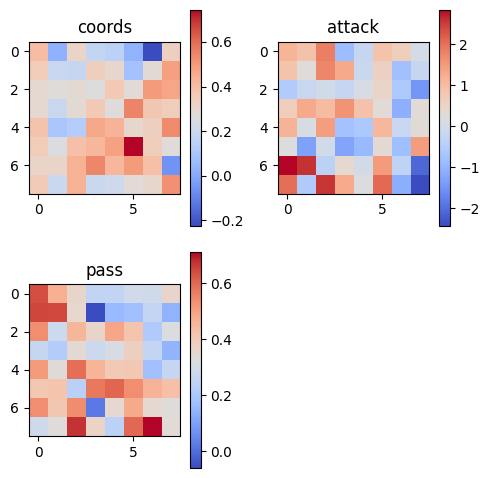

In [25]:
plot_featuremaps(q_target[0], fm_names=['coords', 'attack', 'pass'], separate_cbars=True)

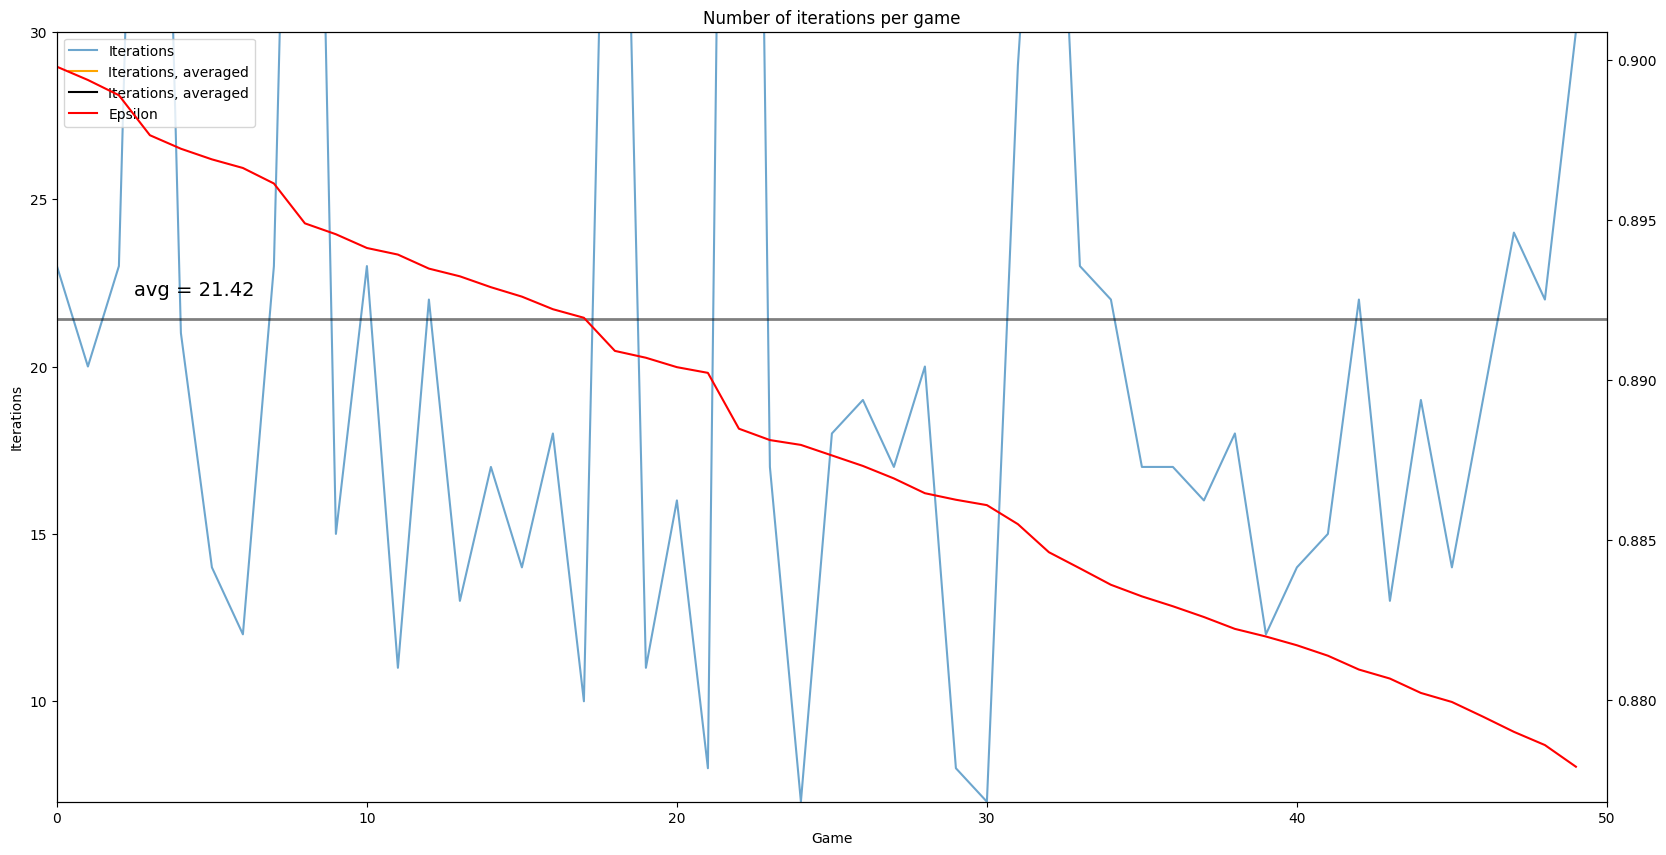

In [26]:
plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=30, figsize=(20, 10), show=False)
if report_results:
    plt.savefig(os.path.join(gen_path, 'training.png'), bbox_inches='tight')
plt.show()

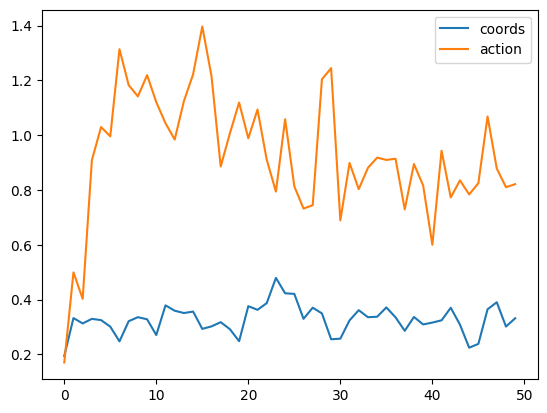

Total number of iterations: 1071


In [27]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()
if report_results:
    plt.savefig(os.path.join(gen_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [28]:
if report_results:
    actual_games = len(iters)

    with open(os.path.join(gen_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after {actual_games / 1000:0.1f}k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")

# Configuration

```python


games = {actual_games}
```
''')

In [29]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 7
Longest game: 87
Number of shortest games: 2


In [30]:
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))

agents_play_loop(agent, agent, game, colormap, reset_epsilon=False, delay=1)

TypeError: object of type 'DnDAgent' has no len()

# Visualization

In [ ]:
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
print_game(game, colormap)

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [ ]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))